Overall intended workflow for Abidjan flood detection. Based on process established by Huang et al. (2015)
    - Import DG image downloaded from GBDX platform
    - Convert geotiff files to numpy array via rasterio
    - Scale to surface reflectance values (divide by 10,000)
    - Define individual bands for later calculations
    - Calculate indices (NDVI, multiple versions of NDWI) and dark parameter
    - Threshold and plot based on Cloud to Street algorithm
    - Calculate MSI 
    - Threshold and plot NDVI, NDWI and MSI
    - Compare output to Cloud-to-Street results
    - Segment final image 
    - Identify characteristics of objects (area, shape, density, length:width ratio, homogeneity)

**References**

Huang, X. and Zhang, L. Morphological Building/Shadow Index for Building Extraction From High-Resolution Imagery Over Urban Areas. IEEE J. Sel. Top. Appl. Earth Obs. Remote. Sens. 2012, 6, 161-172.

Huang, X., Xie, C., Fang, X., Zhang, L. Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 2015, 8, 2097–2110.

### This notebook calculates and plots MSI (from Huang et al (2012))

In [1]:
%matplotlib inline

In [13]:
# Import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import rasterio as rio
from rasterio.mask import mask
from skimage import draw
from skimage.morphology import black_tophat
from skimage.morphology import diamond
import earthpy as et
import earthpy.spatial as es

In [3]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'ndwi-project'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

# Establish consistent font sizes for plots
plt.rcParams.update({'font.size': 15})

In [4]:
# From: https://nbviewer.jupyter.org/github/pratapvardhan/iPyNotebooks/blob/master/Morphological-Gradients.ipynb
# https://github.com/scikit-image/scikit-image/issues/1283

# Function to create a linear structuring element
def selemline(length, theta, dtype=np.uint8):
    """Line structuring element"""
    theta_d = theta * np.pi / 180
    X = int(round((length-1)/2. * np.cos(theta_d)))
    Y = int(-round((length-1)/2. * np.sin(theta_d)))
    C, R, V = draw.line_aa(-X, -Y, X, Y)
    M = 2*max(abs(R)) + 1
    N = 2*max(abs(C)) + 1
    selem = np.zeros((M, N)).astype(dtype)
    selem[R + max(abs(R)), C + max(abs(C))] = 1
    return selem

In [5]:
# Establish path to imagery (update band_path next time)
band_path = "C:/Users/katy/earth-analytics/spring-2019/ndwi-project/dg-data/abidjan-crop-20160617/"
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()

In [7]:
# Create raster stack of all bands
all_bands_path = "C:/Users/katy/earth-analytics/spring-2019/ndwi-project/dg-data/outputs/all_bands.tif"
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [8]:
# Open raster stack as numpy array
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()  

In [9]:
# Scale DG imagery to surface reflectance values (should be between 0 and 1)
all_bands_scaled = all_bands_stack/10000

In [ ]:
# Commented out due to memory issues

# Plot histogram to see if scaled values fall between 0 and 1
# fig,ax = plt.subplots()
# plt.hist(all_bands_scaled.ravel(), bins='auto');

In [ ]:
# Check for max scaled values. 
# print(all_bands_scaled[7].max(), all_bands_stack[7].max())

In [10]:
# Create single band brightness image (max value across all bands)
brightness = all_bands_scaled.max(axis=0)
print(brightness.max(), brightness.min())

2.4562 0.0


In [ ]:
# Commented out due to memory issues

# Plot histogram to explore min and max values
# fig,ax = plt.subplots()
# plt.hist(brightness.ravel(), bins='auto');

In [11]:
# Cap brightness values at a max of 1. Replace all values greater than 1 with a value of 1
brightness_cap = brightness
np.place(brightness_cap, brightness_cap > 1, 1)
print(brightness_cap.max(), brightness_cap.min())

1.0 0.0


In [ ]:
# Commented out due to memory issues

# Plot histogram verifying cap process worked
# fig,ax = plt.subplots()
# plt.hist(brightness_cap.ravel(), bins='auto');

In [ ]:
# Commented out due to memory issues

# # Plot brightness_cap image
# fig, ax = plt.subplots(figsize=(20,10))
# brightness_cap_plot = ax.imshow(brightness_cap, cmap='gray',
#                 vmin=0, vmax=1)
# fig.colorbar(brightness_cap_plot, fraction=.05)
# ax.set(title="Brightness_Cap, June 17, 2016, Abidjan, Cote D'Ivoire\n")
# ax.set_axis_off()
# plt.show()

In [14]:
# Initialize b_tophat_array_sum 
selem = selemline(0,0)
b_tophat_array_sum = black_tophat(brightness_cap, selem)

In [15]:
# Create sum of black tophat morphological profiles.
# Loop and sum black tophat morphological profiles
for i in range(2,57,5):
    for x in range(0, 4):
        selem = selemline(i,45*x)
        b_tophat = black_tophat(brightness_cap,selem)
        b_tophat_array_sum = b_tophat_array_sum.__add__(b_tophat)

In [16]:
# MSI = sum(black-tophat morhpological profiles)/D*S 
# D = 4, S = 11
msi = b_tophat_array_sum/(4*11)
print(msi.max())

0.63799334


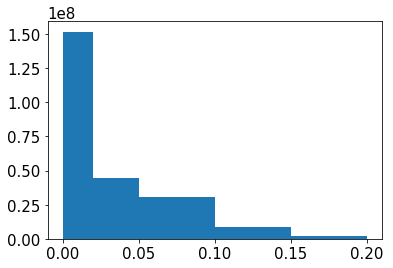

In [39]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(msi.ravel(), bins= [0,0.02,0.05,0.1,0.15,0.2]);

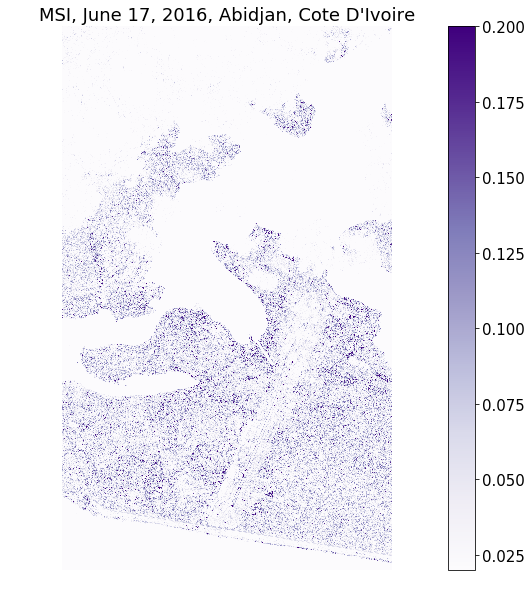

In [42]:
# Plot MSI
fig, ax = plt.subplots(figsize=(20,10))
msi_plot = ax.imshow(msi, cmap='Purples',
                vmin=0.02, vmax=0.2)
fig.colorbar(msi_plot, fraction=0.05)
ax.set(title="MSI, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

In [43]:
# Write out msi file as output
msi_meta = all_bands_meta
msi_meta['count'] = 1

with rio.open('msi_abidjan_crop.tif', 'w', **msi_meta) as dst:
    dst.write(msi, 1)

In [34]:
# Calculate inital shadow mask layer based on msi histogram
shadow = ((msi >= 0.025)).astype(int)

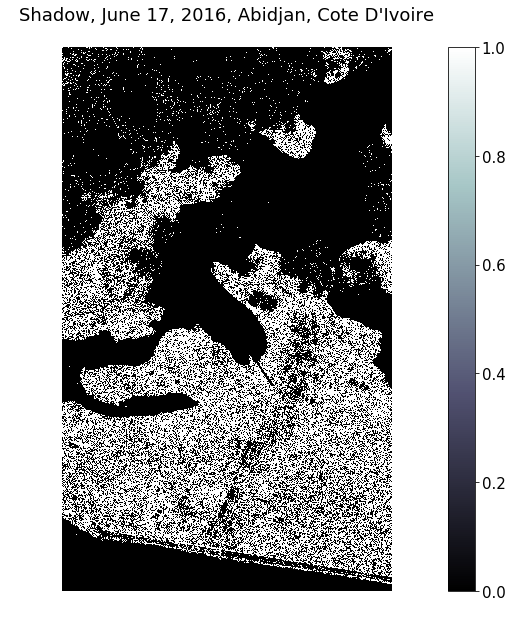

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
shadow_plot = ax.imshow(shadow, cmap='bone',
                vmin=0, vmax=1)
fig.colorbar(shadow_plot, fraction=.05)
ax.set(title="Shadow, June 17, 2016, Abidjan, Cote D'Ivoire\n")
ax.set_axis_off()
plt.show()

In [ ]:
#  # Verify file written out, "msi2" is the same as msi
# msi_path = "C:/Users/katy/earth-analytics/spring-2019/ndwi-project/msi.tif"

# # Open raster stack
# with rio.open(msi_path) as src:
#     msi2 = src.read()  
#     msi2_meta = src.profile
    
# np.array_equal(msi, msi2[0])